In [ ]:
# This is the training code which utilize Vertex AI
! pip install kfp --upgrade
! pip install google-cloud-aiplatform
! pip install pandas
# Install PyPI packages required in this guide, including BentoML
! pip install tensorflow
! pip install apache-beam
! pip install -q --pre bentoml  # install preview version of BentoML for this guide
! pip install -q 'scikit-learn>=0.23.2' 'pandas>=1.1.1'

In [3]:
from kfp.v2 import dsl
from kfp.v2.dsl import (Artifact,
                        Dataset,
                        Input,
                        Model,
                        Output,
                        Metrics,
                        ClassificationMetrics,
                        component)
from kfp.v2 import compiler
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET_NAME = "gs://shawn-taiwan/breast-cancer"
PROJECT_ID= "shawn-demo-2021"
PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, TIMESTAMP)
PIPELINE_ROOT

'gs://shawn-taiwan/breast-cancer/pipeline_root/20211020084149'

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split as tts
import pandas as pd
import numpy as np
    
data_raw = datasets.load_breast_cancer()
data = pd.DataFrame(data_raw.data, columns=data_raw.feature_names)
data["target"] = data_raw.target
    
train, test = tts(data, test_size=0.3)
data.drop(["target"], axis=1).columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [5]:
# Another XGBClassifier Model
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score
model2 = XGBClassifier(
    base_score= np.mean(train['target']),
    eta=0.1,
    max_depth=3,
    gamma=3,
    n_estimatpr=20,
    seed=27,
    silent=0,
    objective='reg:logistic'
)
model2.fit(
    train.drop(columns=["target"]),
    train.target,
)
# Identify from reloaded model
model2.save_model("local-model.dat")
local_model = XGBClassifier()
local_model.load_model("local-model.dat")
y_pred2 = local_model.predict(test.drop(columns=["target"]))
accuracy = accuracy_score(test.target, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[08:41:52] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimatpr", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 97.66%


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [6]:
from kfp.v2 import dsl
from kfp.v2.dsl import (Artifact,
                        Dataset,
                        Input,
                        Model,
                        Output,
                        Metrics,
                        ClassificationMetrics,
                        component)

from kfp.v2 import compiler
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [7]:
# Load Data
@component(
    packages_to_install = [
        "pandas",
        "sklearn",
        "numpy"
    ],
)
def get_data(
    dataset_train: Output[Dataset],
    dataset_test: Output[Dataset]
): 
    from sklearn import datasets
    from sklearn.model_selection import train_test_split as tts
    import pandas as pd
    import numpy as np
    
    data_raw = datasets.load_breast_cancer()
    data = pd.DataFrame(data_raw.data, columns=data_raw.feature_names)
    data["target"] = data_raw.target
    
    train, test = tts(data, test_size=0.3)
    print(" dataset_train.path: "+ dataset_train.path)
    print(" dataset_train.uri: "+ dataset_train.uri)        
    print(" dataset_test.path: "+ dataset_test.path)
    print(" dataset_test.uri: "+ dataset_test.uri)       
    train.to_csv(dataset_train.path)
    test.to_csv(dataset_test.path)

In [8]:
@component(
    packages_to_install = [
        "pandas",
        "sklearn",
        "xgboost"
    ],
)
def train_xgb_model(
    dataset_train: Input[Dataset],
    model_artifact: Output[Model]
):
    from xgboost import XGBClassifier
    import pandas as pd
    
    data = pd.read_csv(dataset_train.path)

    model = XGBClassifier(
        eta=0.1,
        max_depth=3,
        gamma=3,
        n_estimatpr=20,
        seed=27,
        silent=0,
        objective='reg:logistic'
    )
    model.fit(
        data.drop(columns=["target"]),
        data.target,
    )

    score = model.score(
        data.drop(columns=["target"]),
        data.target,
    )

    model_artifact.metadata["train_score"] = float(score)
    model_artifact.metadata["framework"] = "XGBoostClassifier"
    print(" model_artifact.path: "+ model_artifact.path)   
    model.save_model(model_artifact.path)
    

In [9]:
@component(
    packages_to_install = [
        "pandas",
        "sklearn",
        "xgboost"
    ],
)
def eval_model(
    test_set: Input[Dataset],
    xgb_model: Input[Model],
    metrics: Output[ClassificationMetrics],
    smetrics: Output[Metrics]
):
    from xgboost import XGBClassifier
    import pandas as pd
    
    data = pd.read_csv(test_set.path)
    model = XGBClassifier()
    print(" Load Model Path: " + xgb_model.path)
    model.load_model(xgb_model.path)
    
    score = model.score(
        data.drop(columns=["target"]),
        data.target,
    )
    
    from sklearn.metrics import roc_curve
    y_scores =  model.predict_proba(data.drop(columns=["target"]))[:, 1]
    fpr, tpr, thresholds = roc_curve(
         y_true=data.target.to_numpy(), y_score=y_scores, pos_label=True
    )
    metrics.log_roc_curve(fpr.tolist(), tpr.tolist(), thresholds.tolist())
    
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(data.drop(columns=["target"]))
    
    metrics.log_confusion_matrix(
       ["False", "True"],
       confusion_matrix(
           data.target, y_pred
       ).tolist(),  # .tolist() to convert np array to list.
    )
    
    xgb_model.metadata["test_score"] = float(score)
    smetrics.log_metric("score", float(score))

In [10]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline. Use to determine the pipeline Context.
    name="breast-cancer-1",
)
def pipeline():
    dataset = get_data()
    train_op = train_xgb_model(dataset.outputs["dataset_train"])
    eval_op = eval_model(
        test_set=dataset.outputs["dataset_test"],
        xgb_model=train_op.outputs["model_artifact"]
    )

In [11]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(pipeline_func=pipeline, package_path='xgb_pipe_1.json')

In [12]:
from kfp.v2.google.client import AIPlatformClient

api_client = AIPlatformClient(
    project_id="shawn-demo-2021",
    region="asia-east1"
)

response = api_client.create_run_from_job_spec(
    './xgb_pipe_1.json',
)

/opt/conda/lib/python3.7/site-packages/kfp/v2/google/client/client.py:173: FutureWarning: AIPlatformClient will be deprecated in v1.9. Please use PipelineJob https://googleapis.dev/python/aiplatform/latest/_modules/google/cloud/aiplatform/pipeline_jobs.html in Vertex SDK. Install the SDK using "pip install google-cloud-aiplatform"
  category=FutureWarning,


In [13]:
!gsutil cp gs://shawn-taiwan/breast-cancer/pipeline_root/20211018050304/864621875982/breast-cancer-1-20211018050338/train-xgb-model_-3991930896268656640/model_artifact ./cloud_model.dat

Copying gs://shawn-taiwan/breast-cancer/pipeline_root/20211018050304/864621875982/breast-cancer-1-20211018050338/train-xgb-model_-3991930896268656640/model_artifact...
/ [1 files][ 54.7 KiB/ 54.7 KiB]                                                
Operation completed over 1 objects/54.7 KiB.                                     


In [14]:
# Identify from reloaded model
cloud_model = XGBClassifier()
cloud_model.load_model("cloud_model.dat")
y_pred3 = local_model.predict(test.drop(columns=["target"]))
accuracy = accuracy_score(test.target, y_pred3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.66%


In [15]:
%%writefile xgb_service.py
# Create BentoML Inferencing Service
import pandas as pd
import xgboost as xgb
from bentoml import env, artifacts, api, BentoService
from bentoml.adapters import DataframeInput
from bentoml.frameworks.xgboost import XgboostModelArtifact

@env(infer_pip_packages=True)
@artifacts([XgboostModelArtifact('xgbmodel')])
class xgbClassifier(BentoService):
    """
    A minimum prediction service exposing a Scikit-learn model
    """
    @api(input=DataframeInput(), batch=True)
    def predict(self, df):
        # df should be a json double array with a size of Nx30
        data = xgb.DMatrix(data=df)
        return self.artifacts.xgbmodel.predict(data)
        

Overwriting xgb_service.py


In [16]:
from xgb_service import xgbClassifier
import xgboost as xgb
bst = xgb.Booster() # init model
bst.load_model("train-model.dat")      # load data
demo_service = xgbClassifier()
demo_service.pack('xgbmodel', bst)

Accuracy: 97.66%


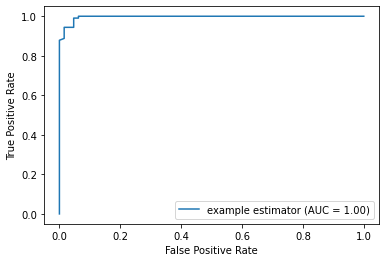

In [17]:
y_pred4 = demo_service.predict(test.drop(columns=["target"]))
y_pred5=pd.cut(demo_service.predict(test.drop(columns=["target"])),bins=[0,0.5,1], labels=[0,1])
accuracy = accuracy_score(test.target, y_pred5)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn import metrics

fpr, tpr, thresholds = roc_curve(
   y_true=test.target.to_numpy(), y_score=y_pred4, pos_label=True
)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()

In [22]:
test_data = test.drop(columns=["target"])
test_data.index[0:2]
test_data.loc[test_data.index[0:2],:]
pred = demo_service.predict(test_data.loc[test_data.index[0:2],:])
pred_binary = pd.cut(pred, bins=[0,0.5,1], labels=[0,1])
test_data.loc[test_data.index[0:2]]
pred

array([0.16325337, 0.27142248], dtype=float32)

In [23]:
# Start a dev model server to test out everything
demo_service.start_dev_server()

[2021-10-20 08:43:45,553] INFO - BentoService bundle 'xgbClassifier:20211020084344_F569A2' created at: /tmp/tmpdtopxr6a
[2021-10-20 08:43:45,583] INFO - ======= starting dev server on port: 5000 =======
[2021-10-20 08:43:46,203] INFO - Starting BentoML API proxy in development mode..
[2021-10-20 08:43:46,204] INFO - Starting BentoML API server in development mode..
[2021-10-20 08:43:46,579] INFO - Micro batch enabled for API `predict` max-latency: 20000 max-batch-size 4000
[2021-10-20 08:43:46,579] INFO - Your system nofile limit is 4096, which means each instance of microbatch service is able to hold this number of connections at same time. You can increase the number of file descriptors for the server process, or launch more microbatch instances to accept more concurrent connection.
 * Serving Flask app 'xgbClassifier' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
[2021-10-20 08:43:56,051] INFO - {'service_name': 'xgbClassifier'

In [24]:
import requests
response = requests.post(
    "http://127.0.0.1:5000/predict",
    json=test_data.loc[test_data.index[0:2],:].values.tolist()
)
print(response.text)

[0.16325336694717407, 0.27142247557640076]


In [26]:
# Stop the dev model server
demo_service.stop_dev_server()

[2021-10-20 08:48:04,939] INFO - Dev server has stopped.


In [28]:
import requests
import google.auth
import google.auth.transport.requests
creds, project = google.auth.default()

# creds.valid is False, and creds.token is None
# Need to refresh credentials to populate those

auth_req = google.auth.transport.requests.Request()
creds.refresh(auth_req)
headers = {"Authorization": "Bearer " + creds.token}
response = requests.post(
    "https://breast-cancer-z6b5qphocq-de.a.run.app/predict",
    json=test_data.loc[test_data.index[0:2],:].values.tolist()
)
print(response.text)



<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>403 Forbidden</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Forbidden</h1>
<h2>Your client does not have permission to get URL <code>/</code> from this server.</h2>
<h2></h2>
</body></html>



'ya29.c.KpABFgjCfeDy0GA87KrWlPZ0JGG8jDkdo6SiimtwagPvYeW1HroP-xaKYeEjjXpJ3k0rmbHNTA709qLxRwE1qOlDgCbbHGroE9TPOuOB9rBv-ECScLxeLYr8p291SJBDiMqG38bsssIdrd4S-9wBcV7hTwJWLtiMjRVG7ufQgE2ynAr87u6aaZzbyHNdy9R_Br8B...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................'

In [30]:
import os
os.system("gcloud config list")

[core]
account = 864621875982-compute@developer.gserviceaccount.com
disable_usage_reporting = True
project = shawn-demo-2021



Your active configuration is: [default]


0